In [10]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import cv2
import pygame



In [11]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

NUM_BINS = [6, 6, 12, 12]
obs_low = env.observation_space.low
obs_high = env.observation_space.high

# Clip velocity & angle for better discretization
obs_low[1] = -0.5
obs_high[1] = 0.5
obs_low[3] = -math.radians(50)
obs_high[3] = math.radians(50)

def discretize(obs):
    ratios = [(obs[i] - obs_low[i]) / (obs_high[i] - obs_low[i]) for i in range(len(obs))]
    bins = [int(ratio * NUM_BINS[i]) for i, ratio in enumerate(ratios)]
    bins = [min(NUM_BINS[i]-1, max(0, b)) for i, b in enumerate(bins)]
    return tuple(bins)

q_table = defaultdict(lambda: np.zeros(env.action_space.n))


In [ ]:
# Initialize Q-learning variables
alpha = 0.1
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 1000

reward_list = []

# Recreate environment for recording
env = gym.make("CartPole-v1", render_mode="rgb_array")

obs = env.reset()[0]
sample_frame = env.render()
height, width, _ = sample_frame.shape
out = cv2.VideoWriter("cartpole_training_recorded.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))

for episode in range(1, episodes + 1):
    obs = env.reset()[0]
    state = discretize(obs)
    total_reward = 0
    done = False

    while not done:
        frame = env.render()
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Annotate frame
        cv2.putText(frame_bgr, f"Episode: {episode}", (40, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255, 255, 0), 2)
        cv2.putText(frame_bgr, f"Q Score: {total_reward:.0f}", (40, 100),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0, 255, 0), 2)
        out.write(frame_bgr)

        # Choose action
        action = np.random.choice(env.action_space.n) if np.random.rand() < epsilon else np.argmax(q_table[state])

        
        # Step the environment
        next_obs, reward, terminated= env.step(action)[:3]
        done = terminated 

        next_state = discretize(next_obs)

        # Q-learning update
        best_next_action = np.argmax(q_table[next_state])
        td_target = reward + gamma * q_table[next_state][best_next_action]
        q_table[state][action] += alpha * (td_target - q_table[state][action])
        state = next_state
        total_reward += reward

    # Record 1s pause between episodes (30 frames)
    for _ in range(30):
        out.write(frame_bgr)

    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    reward_list.append(total_reward)

    if episode % 10 == 0:
        avg = np.mean(reward_list[-10:])
        print(f"Episode {episode}: Avg reward (last 10): {avg:.2f}")

# Final score
final_q_score = np.mean(reward_list[-10:])
print(f"\nFinal Q Score (Avg Reward over last 10 episodes): {final_q_score:.2f}")

out.release()
env.close()
print("🎥 Training video saved as 'cartpole_training_recorded.mp4'")


AttributeError: module 'numpy' has no attribute 'bool8'

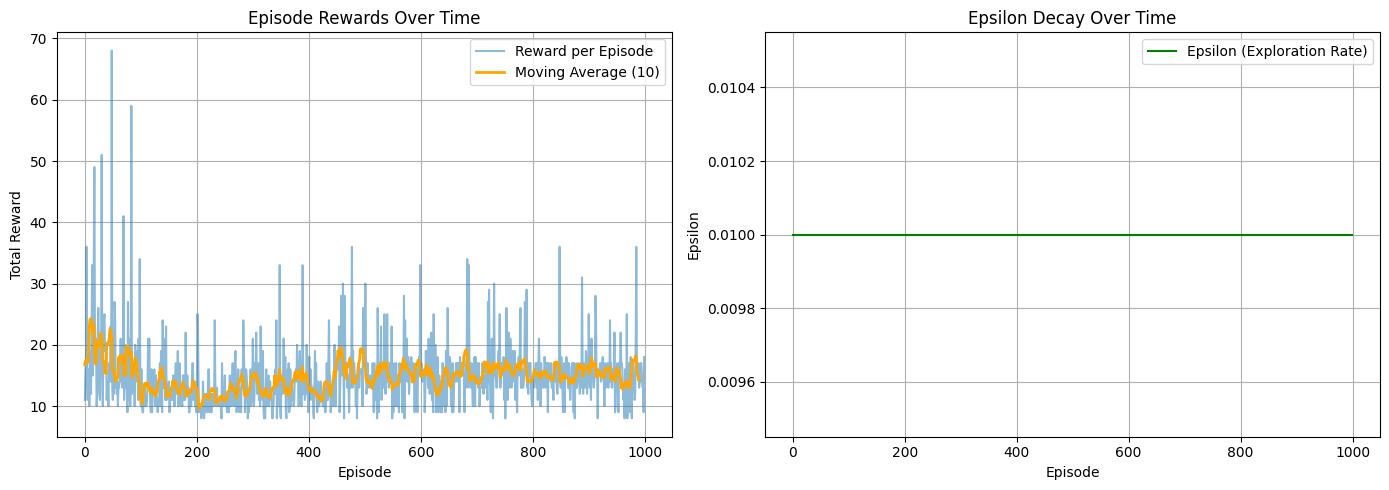

In [ ]:
# Calculate moving average
def moving_average(data, window_size=10):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Plot total rewards & moving average
plt.figure(figsize=(14, 5))

# Reward per episode
plt.subplot(1, 2, 1)
plt.plot(reward_list, label='Reward per Episode', alpha=0.5)
plt.plot(moving_average(reward_list), label='Moving Average (10)', linewidth=2, color='orange')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Episode Rewards Over Time')
plt.legend()
plt.grid(True)

# Epsilon decay over episodes
plt.subplot(1, 2, 2)
epsilons = [max(epsilon_min, epsilon * (epsilon_decay ** i)) for i in range(episodes)]
plt.plot(epsilons, label='Epsilon (Exploration Rate)', color='green')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay Over Time')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
